In [1]:
#import the necessary python libraries for this code
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor, plot_tree,to_graphviz
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestClassifier

In [2]:
 #configure seaborn plot background
sns.set(style="whitegrid")

In [3]:
#define the dateframe as well as the columns that we need for the model
cols = ['isin','fund_trailing_return_ytd', 'social_score', 'environmental_score', 'governance_score', 'sustainability_score']
funds_return_esg = pd.read_csv('Morningstar - European Mutual Funds.csv', usecols=cols)


In [4]:
funds_return_esg.head()

,isin,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
0,LU0011983433,NaN,NaN,NaN,NaN,8.00
1,LU0757425763,2.30,10.48,8.46,21.24,16.59
2,LU0011818076,5.89,10.13,9.25,25.27,-3.20
3,LU0152882725,4.19,10.31,7.75,22.33,9.02
4,LU0114999294,4.19,10.31,7.75,22.33,8.73


In [5]:
#check to see which columns contain missing data and how many missing values in each column
funds_return_esg.isna().sum()

isin                            0
environmental_score         25912
social_score                25912
governance_score            25912
sustainability_score        23027
fund_trailing_return_ytd     2218
dtype: int64

In [6]:
#define the columns that fall under the list numeric_features
numeric_features = ['fund_trailing_return_ytd', 'social_score', 'environmental_score', 'governance_score', 'sustainability_score']
#apply simple imputer to find the missing values and replace with the mean
impute = SimpleImputer(strategy='mean')
funds_return_esg[numeric_features] = pd.DataFrame(impute.fit_transform(funds_return_esg[numeric_features]))
#check to confirm missing values are replaced
funds_return_esg.isna().sum()

isin                        0
environmental_score         0
social_score                0
governance_score            0
sustainability_score        0
fund_trailing_return_ytd    0
dtype: int64

In [7]:
#Evaluate if the fund sustainability score is a summation of the scores
esg_cols = ['social_score', 'environmental_score', 'governance_score']
esg_sum = funds_return_esg[esg_cols].sum(axis=1)
df_esg_sum = esg_sum.to_frame('esg_sum')
df = funds_return_esg.join(df_esg_sum)

df[['isin', 'esg_sum','sustainability_score']].head()

,isin,esg_sum,sustainability_score
0,LU0011983433,22.235258,24.08034
1,LU0757425763,21.240000,21.24000
2,LU0011818076,25.270000,25.27000
3,LU0152882725,22.250000,22.33000
4,LU0114999294,22.250000,22.33000


Since the summation of the esg scores is not the same as the sustainability score we will keep the feature

In [8]:
#next we check to see if thre is any correlation between our data
funds_return_esg.corr()

,environmental_score,social_score,governance_score,sustainability_score,fund_trailing_return_ytd
environmental_score,1.000000,0.811250,0.830907,0.613111,-0.104503
social_score,0.811250,1.000000,0.946229,0.512300,0.049048
governance_score,0.830907,0.946229,1.000000,0.489986,0.021820
sustainability_score,0.613111,0.512300,0.489986,1.000000,-0.034741
fund_trailing_return_ytd,-0.104503,0.049048,0.021820,-0.034741,1.000000


<AxesSubplot:>

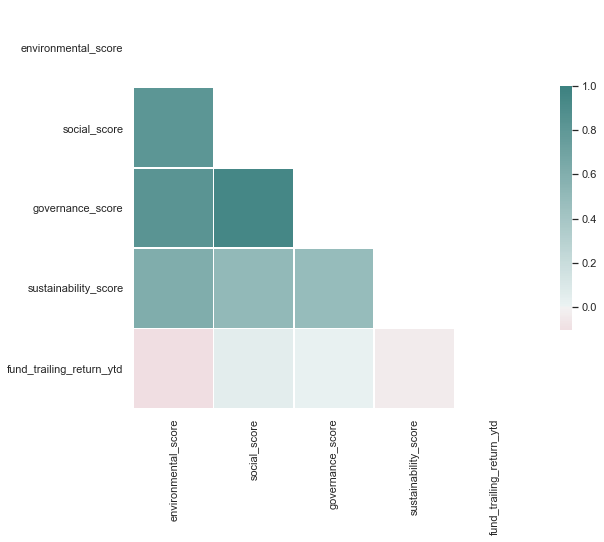

In [9]:
corr = funds_return_esg.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(5, 190, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=1., center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

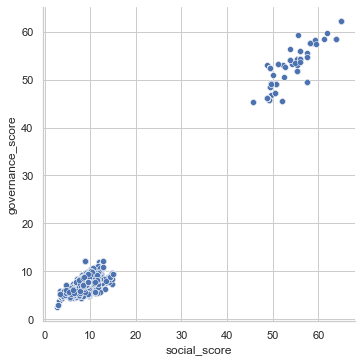

In [10]:
#then we plot the data to find correlations
sns.relplot(x='social_score', y='governance_score',  data=funds_return_esg)

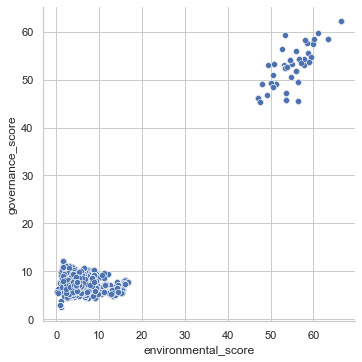

In [11]:
sns.relplot(x='environmental_score', y='governance_score',  data=funds_return_esg)

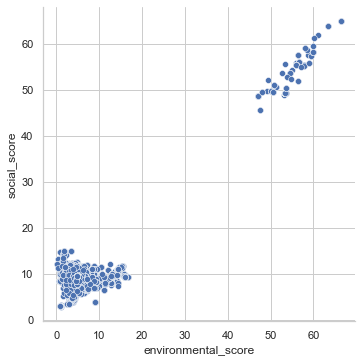

In [12]:
sns.relplot(x='environmental_score', y='social_score',  data=funds_return_esg)

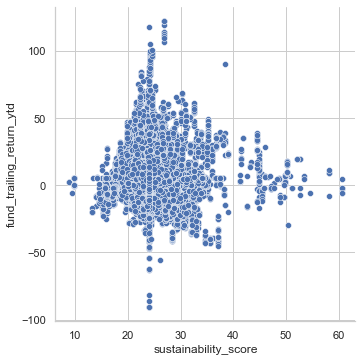

In [13]:
sns.relplot(x='sustainability_score', y='fund_trailing_return_ytd',  data=funds_return_esg)

In [14]:
#convert data to numpy arrays for better processing
np_data = np.array(funds_return_esg)
x = np.float32(np_data[:,1:-1])
y = np.float32(np_data[:,-1])

optimal_guessing = np.mean(y)
optimal_guessing_mean_accuracy = np.mean(abs(y-optimal_guessing))
print("Optimal guessing mean accuracy: ", optimal_guessing_mean_accuracy)

Optimal guessing mean accuracy:  7.509778


Create the regression model. I choose a pretty standard xgboosting regression tree.

In [15]:
#define the variablles, test size and training size
X = funds_return_esg.drop(["isin","fund_trailing_return_ytd"], axis=1)
Y = funds_return_esg["fund_trailing_return_ytd"]

X_train, X_test, y_train, y_test = train_test_split(X, Y,test_size = 0.4, random_state = 100)

In [17]:
# A parameter grid for XGBoost
params = {'min_child_weight':[4,5], 'gamma':[i/10.0 for i in range(3,6)],  'subsample':[i/10.0 for i in range(8,11)],
'colsample_bytree':[i/10.0 for i in range(8,11)], 'max_depth': [2,3,4]}

# Initialize XGB and GridSearch
xgb = XGBRegressor(nthread=-1) 

grid = GridSearchCV(xgb, params)
grid.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=None, nthread=-1,
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, subsample=None,
                                    tree_method=None, validate_parameters=

In [19]:
#show the best parameters
grid.best_params_

{'colsample_bytree': 1.0,
 'gamma': 0.5,
 'max_depth': 4,
 'min_child_weight': 5,
 'subsample': 1.0}

In [22]:
#train the model
xgb = XGBRegressor(colsample_bytree=1.0,gamma=0.5,max_depth=4,min_child_weight=5,subsample=1.0) 
xgb.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.5, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1.0,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
#test the model and score
# Print the r2 score
print(r2_score(y_test, grid.best_estimator_.predict(X_test))) 
print(mean_absolute_error(y_test, grid.best_estimator_.predict(X_test)))

0.5087013991341514
5.485609599217472


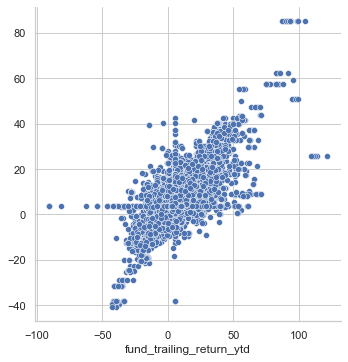

In [26]:
sns.relplot(x=y_test, y=grid.best_estimator_.predict(X_test))

In [27]:
#apply a decision tree model to determine weather to scores are able to accuraltly predict return
clf=RandomForestClassifier(criterion = "gini", random_state = 100)
clf.fit(X_train, y_train)

ValueError: Unknown label type: 'continuous'

In [ ]:
y_pred_clf = clf.predict(X_test)
print ("Random forest Decision Tree Accuracy Score is ", accuracy_score(y_test,y_pred_clf)*100)